In [2]:
import csv
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# <b> Specify each path

In [18]:
dataset = 'C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/data/new_keypoint.csv'
model_save_path = 'C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier_tuning.keras'
tflite_save_path = 'C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier_tuning.tflite'
label_file_path = 'C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/data/keypoint_classifier_label.csv'
# Function to check if a file exists
def check_file_path(file_path):
    if os.path.exists(file_path):
        if os.path.isfile(file_path):
            print(f"File exists: {file_path}")
        else:
            print(f"Path exists, but it's not a file: {file_path}")
    else:
        print(f"File does not exist: {file_path}")

# Check each file
check_file_path(dataset)
check_file_path(model_save_path)
check_file_path(tflite_save_path)
check_file_path(label_file_path)


File exists: C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/data/new_keypoint.csv
File exists: C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier_tuning.keras
File exists: C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier_tuning.tflite
File exists: C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/data/keypoint_classifier_label.csv


# <b> Set Number Of Classes

In [4]:
df = pd.read_csv(label_file_path, header=None)
num_classes= len(df)
num_classes

6

# <b> Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype=np.float32, skiprows=1, usecols=list(range(1, (21*2)+1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype=np.int32, skiprows=1, usecols=(0))

In [6]:
X_dataset

array([[ 0.        ,  0.        , -0.32467532, ..., -0.6103896 ,
         0.15584415, -0.5064935 ],
       [ 0.        ,  0.        , -0.32051283, ..., -0.5769231 ,
         0.12820514, -0.5       ],
       [ 0.        ,  0.        , -0.32051283, ..., -0.5769231 ,
         0.12820514, -0.5       ],
       ...,
       [ 0.        ,  0.        , -0.32954547, ..., -0.6363636 ,
         0.04545455, -0.5568182 ],
       [ 0.        ,  0.        , -0.3218391 , ..., -0.7241379 ,
         0.04597701, -0.62068963],
       [ 0.        ,  0.        , -0.27631578, ..., -0.7105263 ,
         0.09210526, -0.6315789 ]], dtype=float32)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.25, random_state=42)

# <b> Model building

In [8]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(42,)))

    # Hyperparameters
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=40, step=1)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=40, step=1)
    hp_dropout_rate_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    hp_dropout_rate_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # First hidden layer with Dropout
    model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(rate=hp_dropout_rate_1))

    # Second hidden layer with Dropout
    model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(rate=hp_dropout_rate_2))

    # Output layer
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [9]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.5501905679702759

Best val_accuracy So Far: 0.9834815859794617
Total elapsed time: 00h 01m 28s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best fit for learning rate:",best_hps.get('learning_rate'))
print("Best fit for layer 1:",best_hps.get('layer_1'))
print("Best fit for layer 2:",best_hps.get('layer_2'))
print("Best fit for activation function:",best_hps.get('activation'))
print("Best fit for dropout layer 1 function:",best_hps.get('dropout_1'))
print("Best fit for dropout layer 2 function:",best_hps.get('dropout_2') )

Best fit for learning rate: 0.01
Best fit for layer 1: 32
Best fit for layer 2: 37
Best fit for activation function: relu
Best fit for dropout layer 1 function: 0.30000000000000004
Best fit for dropout layer 2 function: 0.0


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(37, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 37)             │         1,221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825 (11.04 KB)

 Trainable params: 2,825 (11.04 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [14]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
hist = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, early_stopping]
)

Epoch 1/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 21s 710ms/step - accuracy: 0.1094 - loss: 1.8951
Epoch 1: saving model to C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1792 - loss: 1.8378 - val_accuracy: 0.3349 - val_loss: 1.7284
Epoch 2/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2188 - loss: 1.7503
Epoch 2: saving model to C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2743 - loss: 1.7269 - val_accuracy: 0.4554 - val_loss: 1.6272
Epoch 3/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3594 - loss: 1.6751
Epoch 3: saving model to C:/GroupPJ/USTHGroupProject/Quang/Hand_Getsure_Clean/model save point/keypoint_classifier.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3689 - loss: 1.6396 - val_accuracy: 0.5950 - val_loss: 1.4694
Epoch 4/1000
 1/31 ━━━━━━━━━━

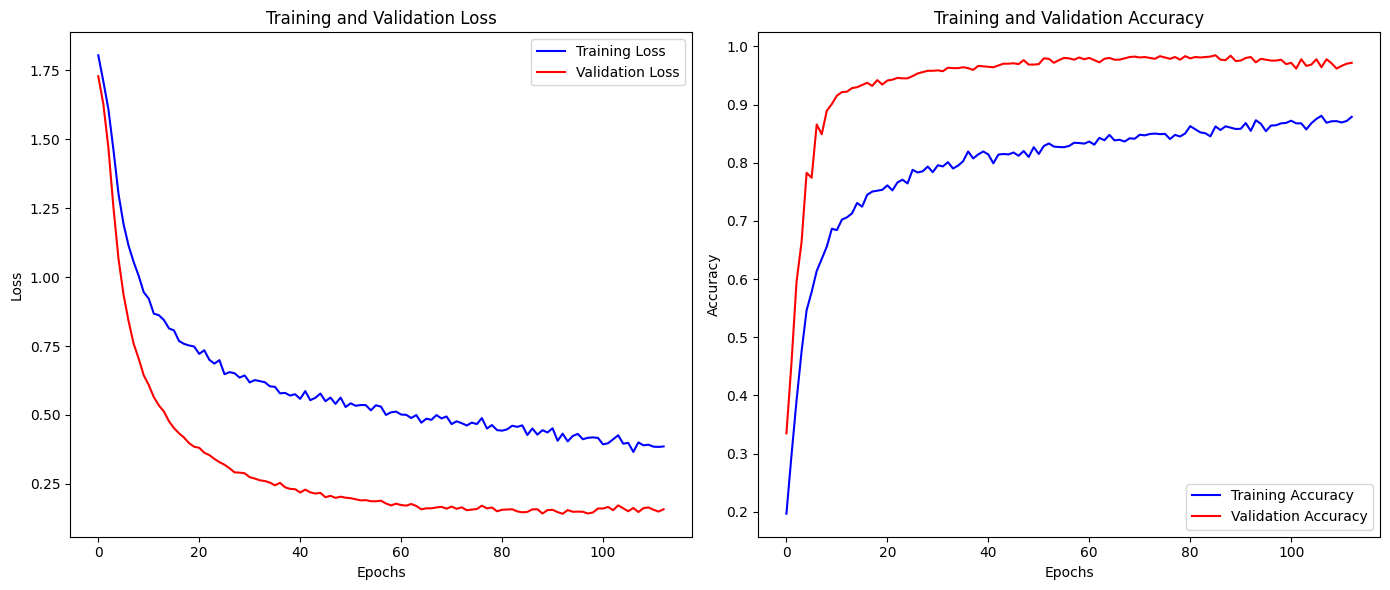

In [16]:
# Extract accuracy and loss data from the training history
history_dict = hist.history

# Create subplots: 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation loss
ax[0].plot(history_dict['loss'], label='Training Loss', color='blue')
ax[0].plot(history_dict['val_loss'], label='Validation Loss', color='red')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the training and validation accuracy
ax[1].plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
ax[1].plot(history_dict['val_accuracy'], label='Validation Accuracy', color='red')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [17]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9683 - loss: 0.1558 


In [19]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [20]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[5.8453943e-04 6.9539863e-07 3.1890699e-03 9.1394585e-01 7.0423730e-02
 1.1856049e-02]
3


# <b> Confusion matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


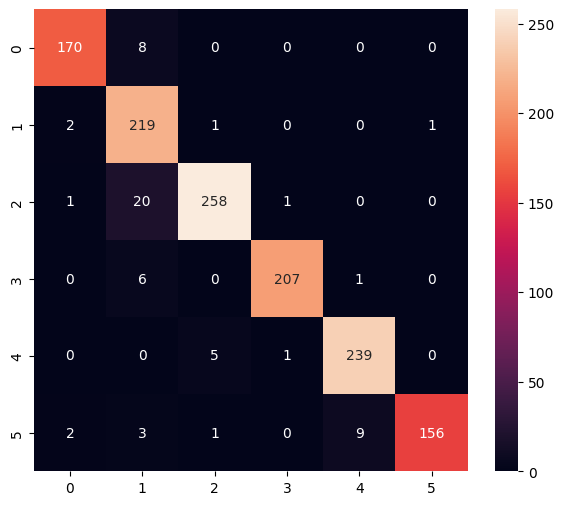

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       178
           1       0.86      0.98      0.91       223
           2       0.97      0.92      0.95       280
           3       0.99      0.97      0.98       214
           4       0.96      0.98      0.97       245
           5       0.99      0.91      0.95       171

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



In [21]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# <b> Convert to model for Tensorflow-Lite

In [22]:
model.save(model_save_path, include_optimizer=False)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,410 (13.32 KB)

 Trainable params: 1,136 (4.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,274 (8.89 KB)

In [23]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\dangq\AppData\Local\Temp\tmpgp7aawb9\assets


INFO:tensorflow:Assets written to: C:\Users\dangq\AppData\Local\Temp\tmpgp7aawb9\assets


Saved artifact at 'C:\Users\dangq\AppData\Local\Temp\tmpgp7aawb9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1959576334080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1959576334608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1959576439264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1959576443312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1959576445072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1959576448064: TensorSpec(shape=(), dtype=tf.resource, name=None)


6624

# <b> Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
print('Input details: \n',input_details)
print('\n')
print('Onput details: \n',output_details)

Input details: 
 [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


Onput details: 
 [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 6]), 'shape_signature': array([-1,  6]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [27]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [28]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 3.92 ms


In [29]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.8453908e-04 6.9539794e-07 3.1890685e-03 9.1394585e-01 7.0423774e-02
 1.1856055e-02]
3
